In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# Predefined ‘magic function’ that display image inline
import matplotlib.image as mimg
# package to help us read in images
import numpy as np
from numpy.random import default_rng
rng=default_rng()  # this is a recommended way to use random number generation now
import os
import random
import math

In [4]:
classes_dict={0:'T-shirt/top',
              1:'Trouser',
              2:'Pullover',
              3:'Dress',
              4:'Coat',
              5:'Sandal',
              6:'Shirt',
              7:'Sneaker',
              8:'Bag',
              9:'Ankle boot'}

In [5]:
def makeDataBase(basename,partition='train',N=None, shuffle=True,normalize=True):
    '''
    This function will create one database that will contain images with their lables
    The data are supposed to be in the paths consisting of
     <basename> / <partition> / <category> / <category>-<index>.jpg
     e.g., FashionMNIST/val/4/4-37.jpg
    Inputs:
        basename (str)  : name of the folder containing all the data. It should be "FashionMNIST"
        partition (str) : "train" or "val" or "test"
        N (int)         : number of examples for each category; when N=None, all samples will be loaded
        shuffle (bool)  : boolean value; if False, samples from category 0 will be returned first and samples from category 9 last
                          if True, samples will be randomly shuffled
        normalize (bool): boolean value; if True, samples are normalized to [-1,1]
    Outputs:
        database (list) : list of tuples (x,y). x is image data. y is numeric label of x 
        
    '''
    database=[]
    for label in range(10): # note: we hardcode number of classes here, it could be another argument
        n = len(os.listdir(os.path.join(basename,partition,str(label)))) if N is None else N
        for i in range(n):          
            imageName=os.path.join(basename,partition,str(label),str(label)+'-'+str(i)+'.jpg')
            imageData=mimg.imread(imageName)
            imageData = np.float32(imageData) if not normalize else np.float32(imageData)/255*2-1
            database.append((imageData,label))
    if shuffle:
        random.shuffle(database)
    return database

In [6]:
def list2ndarray(dataset):
    '''
    This function will take the output from makeDataBase() and return two numpy arrays: X and y
    Inputs:
        dataset (list): list of (sample, label) pairs
    Outputs:
        X (array)     : a 2D numpy array with size (N,D). N is the length of dataset, D is 28*28. 
                        Each row of X is an image sample flattened
        y (array)     : a numpy array with size (N,). y contains numeric labels of corresponding samples
    '''
    num=len(dataset)
    X = np.empty((num,28*28),dtype=np.float32)
    y = np.empty((num,),dtype=int)
    for i in range(num):
        X[i] = dataset[i][0].flatten()
        y[i] = dataset[i][1]
        
    return X, y

In [7]:
def compute_accuracy(yhat,y):
    '''
    This function takes predicted labels and ground truth labels and return accuracy
    Inputs:
        y_hat (array): (N,)-shaped numpy array containing predicted labels OR
                       (N,C) one-hot representation for C classes
        y (array)    : (N,)-shaped numpy array containing ground truth labels OR
                       (N,C) one-hot representation for C classes
    Outputs:
        accu (float) : accuracy between [0.,1.]
    '''
    # if needed, convert from one-hot to class labels
    if len(y.shape) ==2:
        y = np.argmax(y,axis=1)
    if len(yhat.shape) ==2:
        yhat=np.argmax(yhat,axis=1)
    accu = np.count_nonzero(yhat==y)/len(y)
    return accu

You may need to modify the path below to point to wherever you stored the data in Pset 1:

In [8]:
trainset = makeDataBase('../ps1/FashionMNIST',partition='train', N = 100, normalize=True) # this loads the entire training set, you
                                                                                # may want to use N=200 or other N for some steps
trainX, trainy = list2ndarray(trainset)

In [9]:
valset = makeDataBase('../ps1/FashionMNIST',partition='val',normalize=True)
testset = makeDataBase('../ps1/FashionMNIST',partition='test',normalize=True)
valX, valy = list2ndarray(valset)
testX, testy = list2ndarray(testset)

A couple of functions implementing different schedules for the learning rate

In [10]:
def expSchedule(lr,e,delta):
    '''
    This function computes the updates learning rate (lr) at epoch e, using the decay factor delta;
    it returns the new lr which is the old lr multiplied by delta (e is ignored)
    '''
    return lr*delta

In [11]:
def stepSchedule(lr,t,steps):
    '''
    A scheduled adjustment of the learning rate.
    The current learning rate at the end of epoch e is updated according to the argument 'steps':
    steps specifies the schedule; it's a list, with i-th element being a tuple
    of the form (m,d) which means that once t (number of epoch) reaches m, the lr is multiplie
    by d. So, if initial lr is 0.1, and steps is [(10,.5),(20,.1),(30,.1)] then the lr
    will be 0.1 for epochs 0,..,9; 0.05 for epochs 10,..,19; 0.005 for 20,..,29; and .0005 for 
    epochs 29 and on
    '''
    
    for n in range(len(steps)):
        if t==steps[n][0]:
            return lr*steps[n][1]
    return lr    

In [12]:
def scores(W,X):
    '''
    Compute the scores of the classes on data in X
    Inputs:
        W (array): (d,C) matrix of parameters for the C classes
        X (array): (N,d) data matrix of features; may or may not include the constant feature
    Outputs:
        scores (array): (N,C) matrix of scores for each of the N examples and C classes
    '''
   
    if W.shape[0] == X.shape[1]+1: # need to add the constant feature
        X=np.hstack((X,np.ones((X.shape[0],1))))
    return np.dot(X,W)

In [13]:
def softmax(scores):
    '''
    IMPLEMENT THIS
    Compute the class posterior probabilities from the scores
    Inputs:
        scores (array): output of scores()
    Outputs:
        yhat (array): (N,C) matrix of class posteriors for each of the N examples and C classes
    Note: you may want to include the dynamic range shift trick discussed in class
    '''
    N = len(scores)
    C = len(scores[0])
    yhat = np.zeros((N,C))
    for i in range(N):
        maxEle = max(scores[i])

        # prevent overfolow
        each_row = list(map(lambda x: math.exp(x - maxEle), scores[i]))
        denominator = sum(each_row)
        for j in range(C):
            yhat[i][j] = each_row[j]/denominator

    return yhat

In [14]:
def convert_to_one_hot(y, num_values=10):
    """
    Expects a numpy array of labels like [4, 3, 0, ...]
    Outputs: one-hot encoding, e.g. for the above, assuming 10 classes (possible label values)
        [
            [0,0,0,0,1,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0,0,0],
            ....
        ]
    """
    one_hot_labels = np.zeros((y.size, num_values))
    one_hot_labels[np.arange(y.size), y] = 1
    return one_hot_labels


In [15]:
def logLikelihood(yhat,y):
    '''
    IMPLEMENT THIS
    Compute the log-likelihood of the model which produced posterior in yhat corresponding to true labels in y
    Inputs:
        yhat (array): (N,C) posterior matrix like that returned by softmax()
        y (array): (N,C) true labels in one-hot format, or
                   (N,) class labels -- your choice (or the function can handle both)
    Outputs:
        ll (float): the average log-likelihood 
    '''
    N = len(yhat)
    C = len(yhat[0])

    res = 0
    for i in range(N):
        if yhat[i][y[i]] > 0:
            res += math.log(yhat[i][y[i]])
    res = res / N

    return res


In [16]:
def trainSoftmax(X,Y,params):
#     '''
#     IMPLEMENT THIS
#     Inputs:
#         X (array): a (N,d) data matrix of features. Does NOT include the constant feature
#                    (you need to add it if you want to use it)
#         Y (array): a (N,) vector of class labels
#         params (dictionary): specification for hyper-parameters. Must include at least the following:
#           'num_epochs' : max number of epochs for training;
#           'lr' : the (initial) learning rate;
#           'scheduler': the function that takes (lr,e,arg) and updates the lr at the end of epoch e;
#           'lr_update': the arg to pass to scheduler;
#           'batch_size': the size of the mini-batches to use in SGD
          
#     Outputs:
#         W (array): an (d,C) matrix of parameters
#         NLL: the list of values of negative average log-likelihood of the softmax model on the training data, 
#              one number for each training epoch covered.
    # '''
  
    num_epochs = params['num_epochs']
    lr = params['lr']
    scheduler = params['scheduler']
    lr_update = params['lr_update']
    batch_size = params['batch_size']

    epoch = 0
    N = len(X)
    d = len(X[0])

    W = np.zeros((d, 10))
    NLL = np.zeros(num_epochs)

    while (epoch < num_epochs):
        if (batch_size > N):
            print("ERROR: Batch Size larger than sample size")
            exit(-1)
        
        avg_grad = 0
        idx = np.random.choice(range(N), size = batch_size, replace = False) 
        #idx = list(np.random.randint(N, size = batch_size))
        for i in idx: # x is 1 x d

            true_class = Y[i]
            predict = np.matmul(X[i], W)
            max_val = max(predict)

            each_row = list(map(lambda x: math.exp(x - max_val), predict))
            numerator = each_row[true_class]
            denominator = sum(each_row)

            grad = - X[i] + X[i] * (numerator/denominator)
            avg_grad += (grad / batch_size)
            W[:, true_class] -= lr * grad 

        scores_mat = scores(W, X)
        yhat = softmax(scores_mat)
        NLL[epoch] = logLikelihood(yhat, Y)

        epoch += 1
        
    return W, NLL

In [17]:
# example of setting the params list to pass to the training code; add your own elements that
# specify stopping criteria and anything else
params={'lr':.1, 'num_epochs':40,'scheduler': stepSchedule,'batch_size':200,'lr_update':[(20,.5),(30,.1)]}

Once you complete the code, follow the problem set assignment, run the experiments, and report your findings.

In [18]:
# trainset made specifically for hyperparameter tuning
trainset = makeDataBase('../ps1/FashionMNIST',partition='train',normalize=True, N = 200) # this loads the entire training set, you
                                                                                # may want to use N=200 or other N for some steps
trainX_val, trainy_val = list2ndarray(trainset)

In [19]:
W, NLL = trainSoftmax(trainX, trainy, params)
predict = softmax(scores(W, testX))
N = len(testX)
y_predict = np.zeros(N)
for i in range(N):
    y_predict[i] = np.argmax(predict[i])

acc = compute_accuracy(y_predict, testy)
print("acc", acc)

acc 0.6971


The process for choosing good parameter:
There are two learning rate updating mechanism. Hence, I will find the best
parameter for schedule procedure and exp procedure respectively, and compare them
at the end to find the best learning rate updating mechanism.

Fixing a learning rate update mechanism, I will find a plausible set of learning rate,
num_epochs, patch size, and update step, and I will loop around all possibilities to
find the optimal hyperparameter.

In [20]:
lr_lst = [0.1, 0.05,0.5, 1]
num_epochs = [10, 40, 100]
batch_size = [ 100, 200, 500]
update = [[(20,.5),(30,.1)], [(10,.5),(20,.1),(30,.2)], [(50,.5),(100,.1)]]

best_acc = 0
best_lr = 0
best_num_epoch = 0
best_batch_size = 0
best_update_index = 0

for lr_i in lr_lst:
    for j in num_epochs:
        for l in batch_size:
                for h in range(len(update)): 
                    params={'lr':lr_i, 'num_epochs':j,'scheduler': stepSchedule,'batch_size':l,'lr_update':update[h]}
                    W, NLL = trainSoftmax(trainX, trainy, params)
                    predict = softmax(scores(W, valX))

                    N = len(valX)
                    y_predict = np.zeros(N)
                    for i in range(N):
                        y_predict[i] = np.argmax(predict[i])

                    acc = compute_accuracy(y_predict, valy)
                    if (acc > best_acc):
                        best_acc = acc
                        best_lr = lr_i
                        best_num_epoch = j
                        best_batch_size = l
                        best_update_index = update[h]

print("The best accuracy rate is {}".format(best_acc))
print("The best learning rate is {}".format(best_lr))
print("The best number of epoch is {}".format(best_num_epoch))
print("The best batch size is {}".format(best_batch_size))
print("the best update index is {}".format(best_update_index))


The best accuracy rate is 0.7023
The best learning rate is 0.5
The best number of epoch is 100
The best batch size is 200
the best update index is [(20, 0.5), (30, 0.1)]


In [22]:
lr_lst = [0.1, 0.05,0.5, 1]
num_epochs = [10, 40, 100]
batch_size = [ 100, 200, 500]
decay_rate = [0.1, 0.5, 0.8]

best_acc = 0
best_lr = 0
best_num_epoch = 0
best_batch_size = 0
best_decay_rate = 0

for lr_i in lr_lst:
    for j in num_epochs:
        for l in batch_size:
            for d in decay_rate:
                params={'lr':lr_i, 'num_epochs':j,'scheduler': expSchedule,'batch_size':l,'lr_update':d}

                W, NLL = trainSoftmax(trainX, trainy, params)
                predict = softmax(scores(W, valX))

                N = len(valX)
                y_predict = np.zeros(N)
                for i in range(N):
                    y_predict[i] = np.argmax(predict[i])

                acc = compute_accuracy(y_predict, valy)
                if (acc > best_acc):
                    best_acc = acc
                    best_lr = lr_i
                    best_num_epoch = j
                    best_batch_size = l
                    best_decay_rate = d

print("The best accuracy rate is {}".format(best_acc))
print("The best learning rate is {}".format(best_lr))
print("The best number of epoch is {}".format(best_num_epoch))
print("The best batch size is {}".format(best_batch_size))
print("the best update index is {}".format(best_decay_rate))         

The best accuracy rate is 0.7096
The best learning rate is 1
The best number of epoch is 100
The best batch size is 100
the best update index is 0.5


As the result produced by the expSchedule is better, I will use expSchedule.
This is the list of hyperparameters that I use:

learning rate = 0.5,
num of epoch = 10,
batch size = 100
best decay rate is 0.5
The best accuracy rate on the val set is 0.7096

Then we implement it on the test set


In [28]:
params={'lr':0.5, 'num_epochs': 10,'scheduler': expSchedule,'batch_size': 100,'lr_update': 0.5}


W, NLL = trainSoftmax(trainX, trainy, params)
predict = softmax(scores(W, testX))

N = len(valX)
y_predict = np.zeros(N)
for i in range(N):
    y_predict[i] = np.argmax(predict[i])

acc = compute_accuracy(y_predict, testy)
print(acc)
print(NLL)

0.6183
[ -73.51126614  -89.82571473  -69.5969461  -137.68958441  -72.65077626
  -75.32640781  -90.21866074  -85.79064326  -77.43341326  -59.47523572]


The accuracy rate on the testing set is 0.6183.

In [33]:
W.shape

(784, 10)

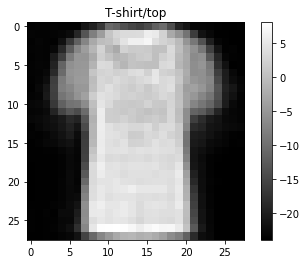

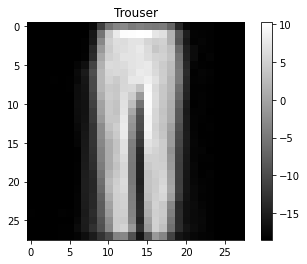

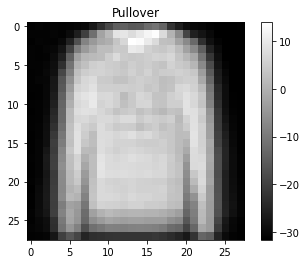

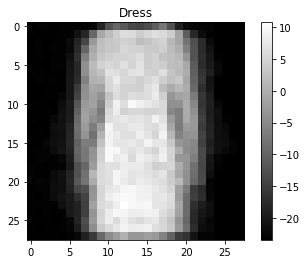

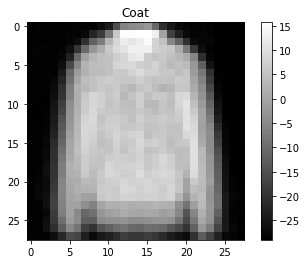

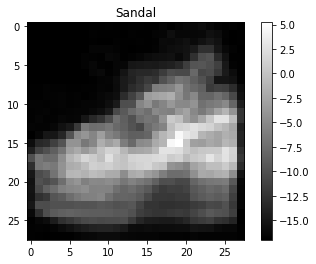

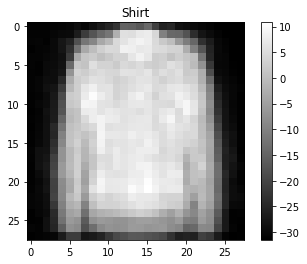

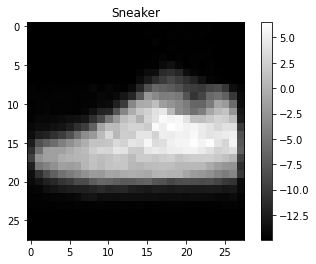

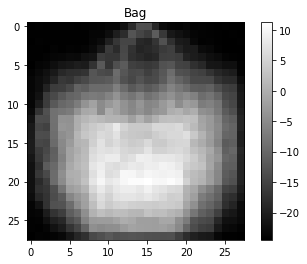

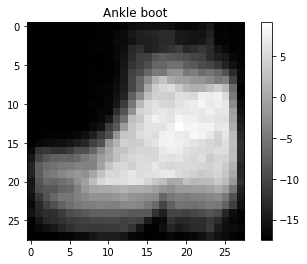

In [32]:
for c in range(10):
    plt.imshow(W[-28**2:, c].reshape(28, 28),cmap="gray")
    plt.colorbar()
    plt.title(classes_dict[c])
    plt.show()

As you can easily observe from the above plots, the parameters form the shape of its
corresponding clothes. The intuition is that the darker portion represents the pixels
that are not related to the clothes (thus the corresponding parameter is negative, and the
model gets penalized), while the ligher portion represents the pixels that are
related to the clothes (thus the corresponding parameter is positive, and the model gets
rewarded.) This explains why the lighter portion has the shape of the clothes.